In [10]:
import matplotlib as mpl
mpl.rcParams.update({
    "figure.facecolor": "white",
    "axes.facecolor": "white",
    "savefig.facecolor": "white",
    "text.color": "black",
    "axes.labelcolor": "black",
    "axes.edgecolor": "black",
    "xtick.color": "black",
    "ytick.color": "black",
})

# Sweep analysis (interactive)

This notebook summarizes the sweep and lets you drill into specific runs.

In [11]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

def find_repo_root(start: Path) -> Path:
    for parent in [start, *start.parents]:
        if (parent / "pyproject.toml").exists():
            return parent
    return start

root = find_repo_root(Path.cwd())
sweep_dir = root / "data" / "sim_sweep"
summary_path = sweep_dir / "summary.csv"

if not summary_path.exists():
    raise FileNotFoundError(
        f"Missing {summary_path}. Run: uv run ./scripts/analyze_sweep.py"
    )

summary = pd.read_csv(summary_path)
index = pd.read_csv(sweep_dir / "index.csv")
summary.head()

,early_mean_error,late_mean_error,adapt_gain,early_slope,mean_k_early,corr_rpost1_delta,corr_delta_rmeasure,run_id,run_name,model,beta,lam,delta_pi_sd,rho,plateau_frac,seed
0,-3.655225,-0.149433,-3.505792,0.886008,0.200294,-0.112172,-0.112172,1,M0_b0_l0_d0p5_r0_p0_s0,M0,0.0,0.0,0.5,0.0,0.00,0
1,-3.536136,-0.141920,-3.394216,0.909849,0.202433,-0.065201,-0.065201,2,M0_b0_l0_d0p5_r0_p0_s1,M0,0.0,0.0,0.5,0.0,0.00,1
2,-1.840225,1.665567,-3.505792,0.886008,0.200294,-0.112172,-0.112172,3,M0_b0_l0_d0p5_r0_p0p15_s0,M0,0.0,0.0,0.5,0.0,0.15,0
3,-1.721136,1.673080,-3.394216,0.909849,0.202433,-0.065201,-0.065201,4,M0_b0_l0_d0p5_r0_p0p15_s1,M0,0.0,0.0,0.5,0.0,0.15,1
4,-3.655225,-0.149433,-3.505792,0.886008,0.200294,0.162673,0.162673,5,M0_b0_l0_d0p5_r0p3_p0_s0,M0,0.0,0.0,0.5,0.3,0.00,0


## Early learning slope vs modulation strength

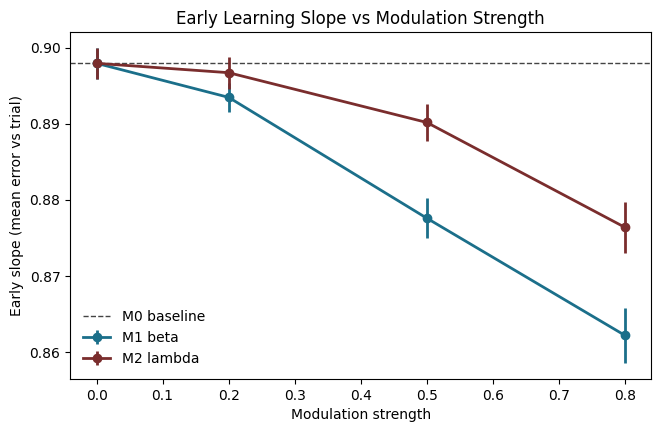

In [12]:
fig, ax = plt.subplots(figsize=(7.5, 4.5))

m0 = summary[summary["model"] == "M0"]["early_slope"].mean()
ax.axhline(m0, color="#444444", ls="--", lw=1, label="M0 baseline")

for model, strength_col, label, color in [
    ("M1", "beta", "M1 beta", "#1b6f8a"),
    ("M2", "lam", "M2 lambda", "#7a2d2d"),
]:
    sub = summary[summary["model"] == model]
    grouped = sub.groupby(strength_col)["early_slope"]
    x = grouped.mean().index.values
    y = grouped.mean().values
    yerr = grouped.sem().values
    ax.errorbar(x, y, yerr=yerr, marker="o", lw=2, color=color, label=label)

ax.set_xlabel("Modulation strength")
ax.set_ylabel("Early slope (mean error vs trial)")
ax.set_title("Early Learning Slope vs Modulation Strength")
ax.legend(frameon=False)
plt.show()

## Plateau confound check

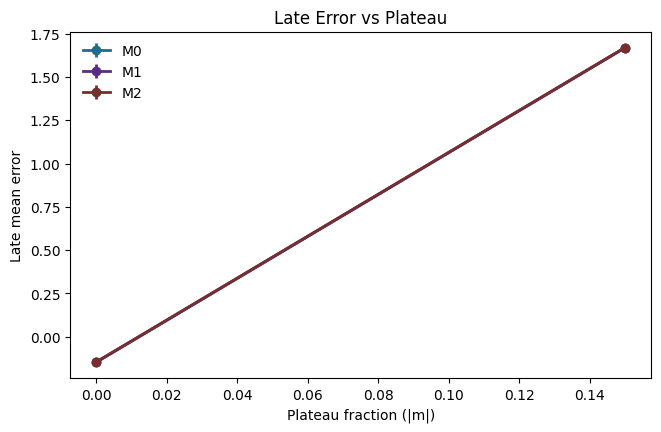

In [13]:
fig, ax = plt.subplots(figsize=(7.5, 4.5))

for model, color in [("M0", "#1b6f8a"), ("M1", "#5b2c83"), ("M2", "#7a2d2d")]:
    sub = summary[summary["model"] == model]
    means = sub.groupby("plateau_frac")["late_mean_error"].mean()
    sems = sub.groupby("plateau_frac")["late_mean_error"].sem()
    ax.errorbar(
        means.index.values,
        means.values,
        yerr=sems.values,
        marker="o",
        lw=2,
        color=color,
        label=model,
    )

ax.set_xlabel("Plateau fraction (|m|)")
ax.set_ylabel("Late mean error")
ax.set_title("Late Error vs Plateau")
ax.legend(frameon=False)
plt.show()

## Drill into a specific run

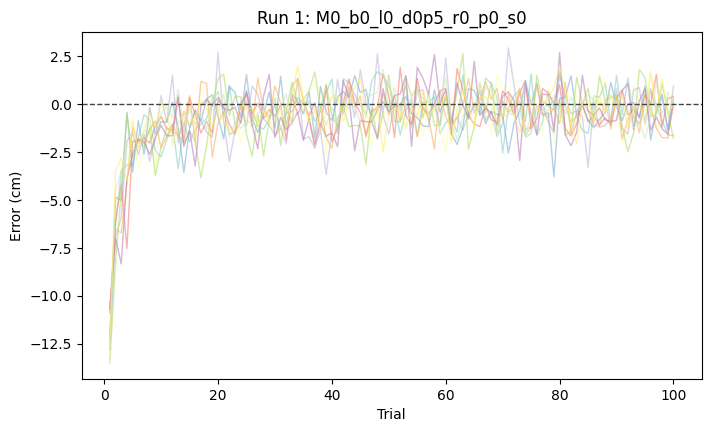

In [14]:
run_id = 1
row = summary[summary["run_id"] == run_id].iloc[0]
idx_row = index[index["run_id"] == run_id].iloc[0]
run_dir = Path(idx_row["output_dir"])
if not run_dir.is_absolute():
    run_dir = root / run_dir
trials = pd.read_csv(run_dir / "sim_trials.csv")

fig, ax = plt.subplots(figsize=(8, 4.5))
for subject in trials["subject"].unique()[:10]:
    sub = trials[trials["subject"] == subject]
    ax.plot(sub["trial"], sub["error"], alpha=0.6, lw=1)
ax.axhline(0, color="#444444", lw=1, ls="--")
ax.set_xlabel("Trial")
ax.set_ylabel("Error (cm)")
ax.set_title(f"Run {run_id}: {row['run_name']}")
plt.show()

## Results snapshots

Quick summaries to mirror `Results.md`.

In [15]:
summary.groupby(["model", "plateau_frac"])["late_mean_error"].mean().unstack()

plateau_frac,0.00,0.15
model,,
M0,-0.145676,1.669324
M1,-0.147340,1.667660
M2,-0.145009,1.669991


### Per-seed variability (early slope)

This shows whether the effect is stable across seeds.

In [16]:
summary.groupby(["model", "seed"])["early_slope"].agg(["mean", "std"]).sort_index()

mean           std
model seed                        
M0    0     0.886008  7.616067e-17
      1     0.909849  0.000000e+00
M1    0     0.872486  1.804979e-02
      1     0.893108  1.885111e-02
M2    0     0.876472  1.235583e-02
      1     0.904118  8.529294e-03

### Delta_pi sign split (early |error|)

This checks whether modulation effects differ for positive vs negative tuning.

In [17]:
run_id = 1
row = summary[summary["run_id"] == run_id].iloc[0]
idx_row = index[index["run_id"] == run_id].iloc[0]
run_dir = Path(idx_row["output_dir"])
if not run_dir.is_absolute():
    run_dir = root / run_dir

trials = pd.read_csv(run_dir / "sim_trials.csv")
subjects = pd.read_csv(run_dir / "sim_subjects.csv")

early = trials[trials["trial"] <= 10]
early_mean = early.groupby("subject")["error"].mean().reset_index()
early_mean["abs_error"] = early_mean["error"].abs()
merged = subjects.merge(early_mean, on="subject", how="inner")
merged["delta_sign"] = (merged["delta_pi"] >= 0).map({True: "pos", False: "neg"})
merged.groupby("delta_sign")["abs_error"].mean()

delta_sign
neg    3.740379
pos    3.585553
Name: abs_error, dtype: float64

## Delta precision vs early error (summary plot)

Correlation between Δπ and early |error| across runs, by modulation strength.

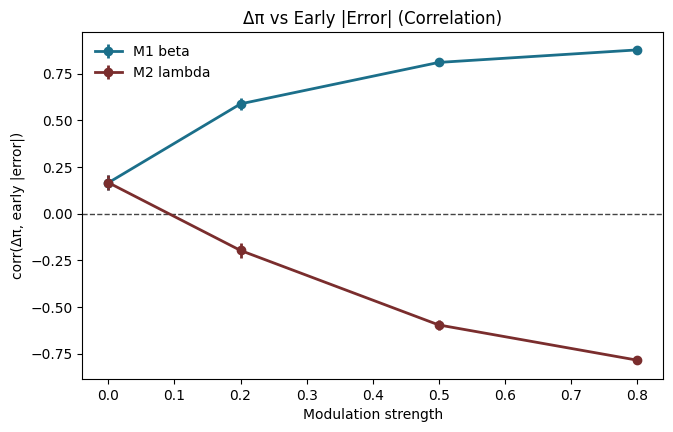

In [18]:
import numpy as np

def corr_delta_early_abs_error(run_dir: Path) -> float:
    trials = pd.read_csv(run_dir / "sim_trials.csv")
    subjects = pd.read_csv(run_dir / "sim_subjects.csv")
    early = trials[trials["trial"] <= 10]
    early_mean = early.groupby("subject")["error"].mean().reset_index()
    early_mean["abs_error"] = early_mean["error"].abs()
    merged = subjects.merge(early_mean, on="subject", how="inner")
    return float(np.corrcoef(merged["delta_pi"], merged["abs_error"])[0, 1])

corr_rows = []
for _, row in index.iterrows():
    run_dir = Path(row["output_dir"])
    if not run_dir.is_absolute():
        run_dir = root / run_dir
    corr_rows.append({
        "run_id": row["run_id"],
        "model": row["model"],
        "beta": row["beta"],
        "lam": row["lam"],
        "corr": corr_delta_early_abs_error(run_dir),
    })

corr_df = pd.DataFrame(corr_rows)

fig, ax = plt.subplots(figsize=(7.5, 4.5))
for model, strength_col, label, color in [
    ("M1", "beta", "M1 beta", "#1b6f8a"),
    ("M2", "lam", "M2 lambda", "#7a2d2d"),
]:
    sub = corr_df[corr_df["model"] == model]
    grouped = sub.groupby(strength_col)["corr"]
    x = grouped.mean().index.values
    y = grouped.mean().values
    yerr = grouped.sem().values
    ax.errorbar(x, y, yerr=yerr, marker="o", lw=2, color=color, label=label)

ax.axhline(0, color="#444444", lw=1, ls="--")
ax.set_xlabel("Modulation strength")
ax.set_ylabel("corr(Δπ, early |error|)")
ax.set_title("Δπ vs Early |Error| (Correlation)")
ax.legend(frameon=False)
plt.show()

## Collinearity stress visualization

Target rho vs realized corr(r_post1, Δπ) per run.

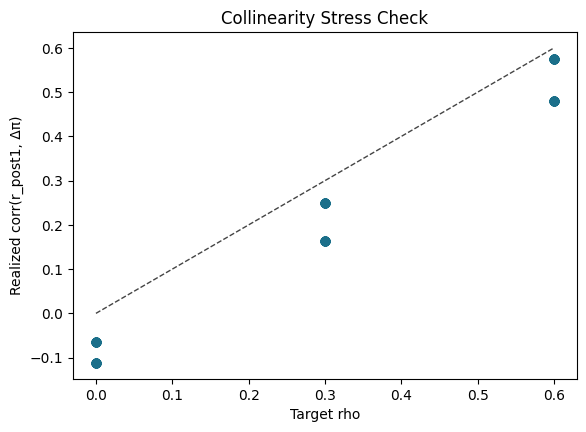

In [19]:
fig, ax = plt.subplots(figsize=(6.5, 4.5))
ax.scatter(summary["rho"], summary["corr_rpost1_delta"], alpha=0.6, color="#1b6f8a")
ax.plot([summary["rho"].min(), summary["rho"].max()],
        [summary["rho"].min(), summary["rho"].max()],
        color="#444444", lw=1, ls="--")
ax.set_xlabel("Target rho")
ax.set_ylabel("Realized corr(r_post1, Δπ)")
ax.set_title("Collinearity Stress Check")
plt.show()